In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from preprocess_functions import preprocess #preprocess is a class containing all the function

## Set up paths and params, then load data and fill object
path is the root_data path as defined in https://github.com/ikharitonov/vestibular_vr_pipeline/issues/25)

Select sensors if sensor-specific (and not "auto") filtering is used. 'G8m', 'g5-HT3', 'rG1' or available sensors in the function, otherwise asks for user input for half decay time in ms.

Target area is the intended area, not verified by histology yet. Added to self.info dictionary.  

In [3]:
path = '/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2717-2024-12-12T12-54-49'
sensors = {'470':'g5-HT3', '560':'rG1', '410':'g5-HT3'}
target_area = ('X') 

In [4]:
#Create an object which will contain an increasing amount of information as functions are called on
processed = preprocess(path, sensors)
# extract all relevant and irrelevant info from the Fluorescence.csv file which contains the metadata 
processed.info = processed.get_info()

In [5]:
#Loads Events.csv and Fluorescence-unaligned.csv
#Aligns to 470 nm timestamps (assumes 470 exists) and cuts data if needed (almost never)
#Returns processed dataframes below
(
    processed.rawdata, 
    processed.data, 
    processed.data_seconds, 
    processed.signals, 
) = processed.create_basic(
    cutstart = False,
    cutend = False,
    target_area = target_area
)


Preprocessing data for B6J271 in session 2024-12-12T12-54-49...



In [6]:
#Not sure why is even needed, not using currently, asked Hilde for clarification in issue #4
#processed.events = processed.extract_events()
'''
now we have an element 'events' containing timestamped events
for each event there will be a _starts and a _stops and a _event
 _starts: numpy nans for all rows except at the time stamp where the event starts
 _stops: numpy nans for all rows except at the time stamp where the event stops
 _events: False whenever the event did not take place, and True while it did take place
 The event is named the same as was as it was recorded
'''
#processed.events
None

### Filtering
All the sigals are low pass filtered using a butterworth filter.  
method = "auto" cutoff frequncy ~sample_rate/2 Hz  
method = "sensor" cutoff frequency is determined in the function using the sensors dictionary  
savefig = False by default, True will save the figure 

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz


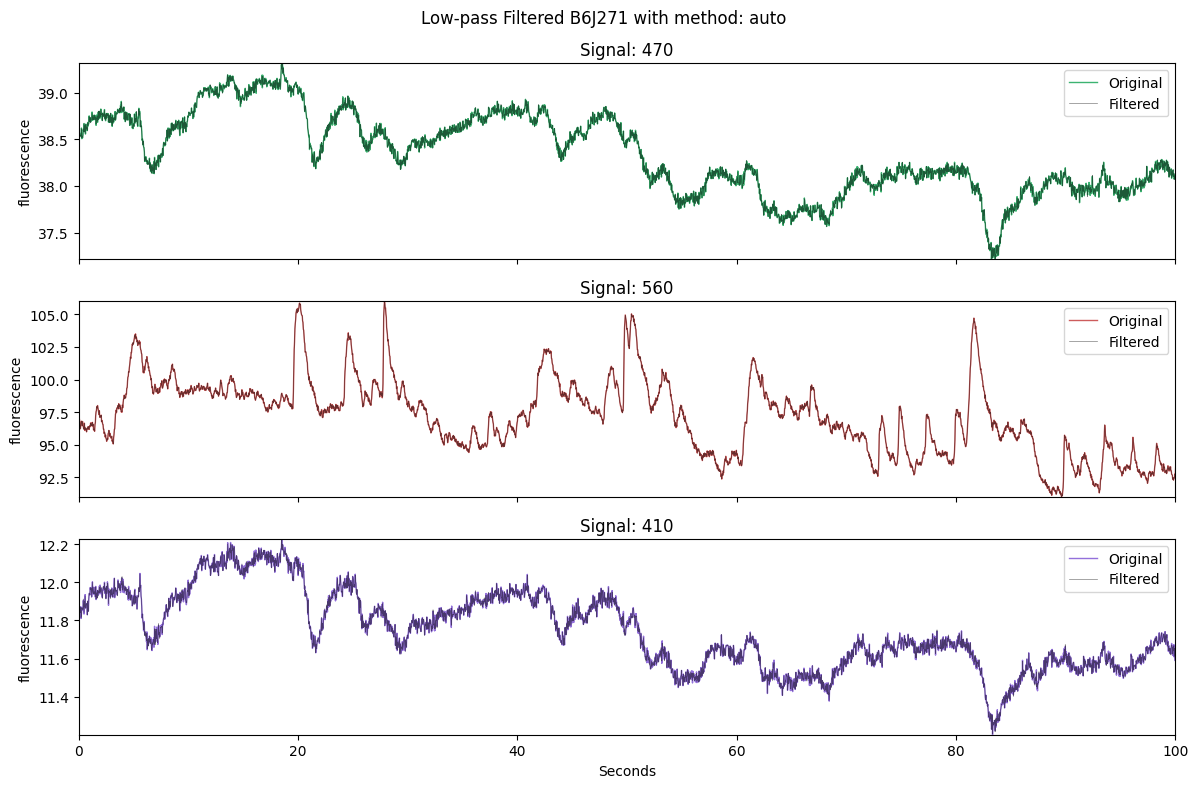

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz


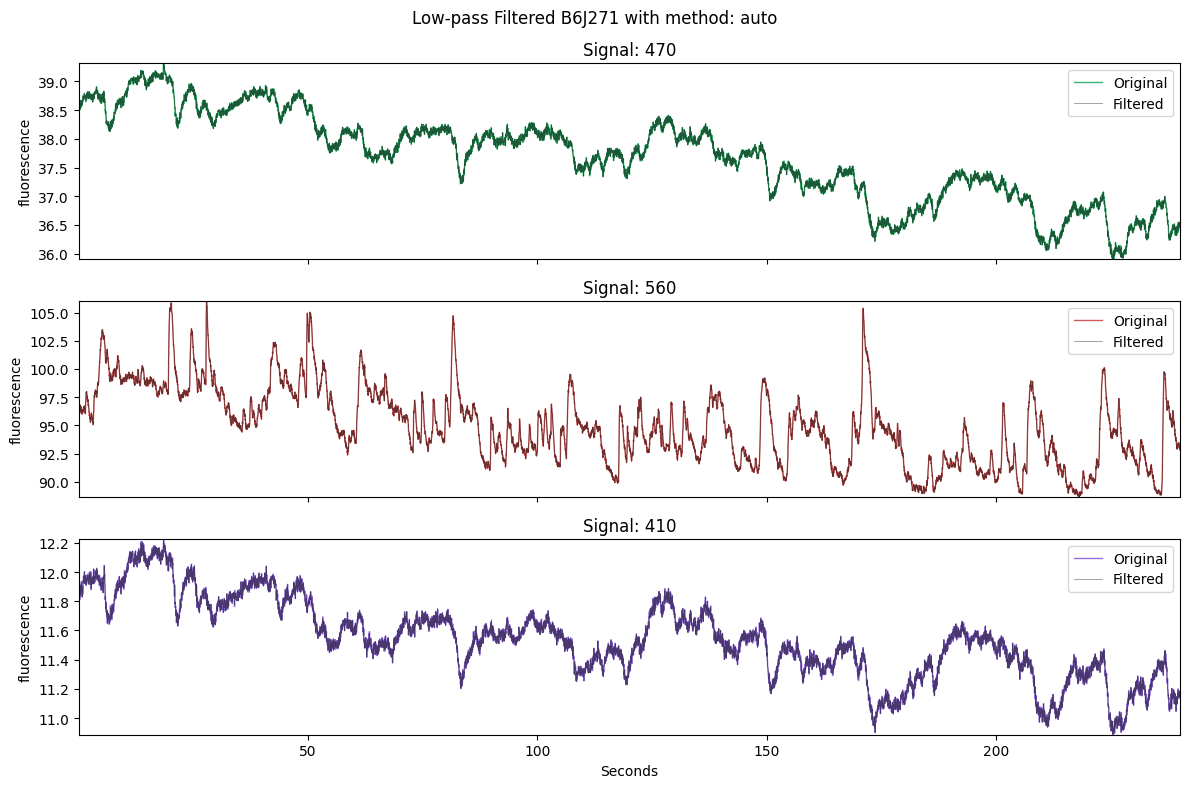

In [7]:
processed.filtered = processed.low_pass_filt(method = "auto", plot=True, x_start=0, x_end=100) #for inspection
processed.filtered = processed.low_pass_filt(method = "auto", plot=True)

### Detrending
A double exponential fit is made to account for sources of bleaching and the signal is corrected.  
method = "subtractive" assumes bleaching is sensor-independent (e.g. autofluorescence)  
method = "divisive" assumes bleaching comes from the sensor. This is most plausible.  
savefig = False by default, True will save the figure  
**N.B.** divisive detrended data is already dF/F. 

Detrending filtered_470 with params: [2.41e-06, 25.7, 38.9, 3.74e+03, 3.39e-08]
Detrending filtered_560 with params: [90.8, 0.53, 9.36, 124, 6.82e-08]
Detrending filtered_410 with params: [10.9, 5.38, 1.1, 204, 7.75e-07]


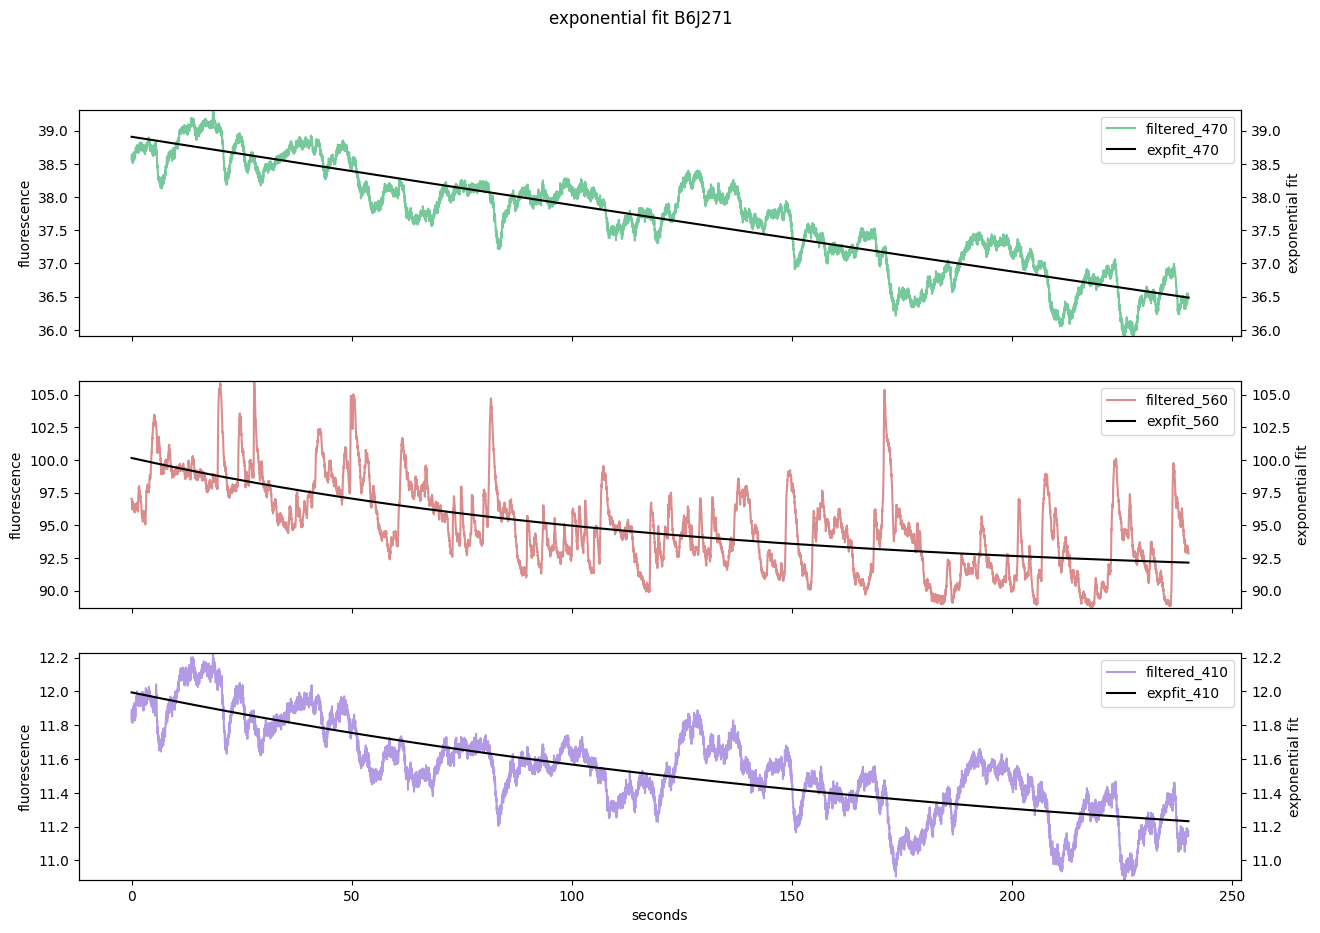

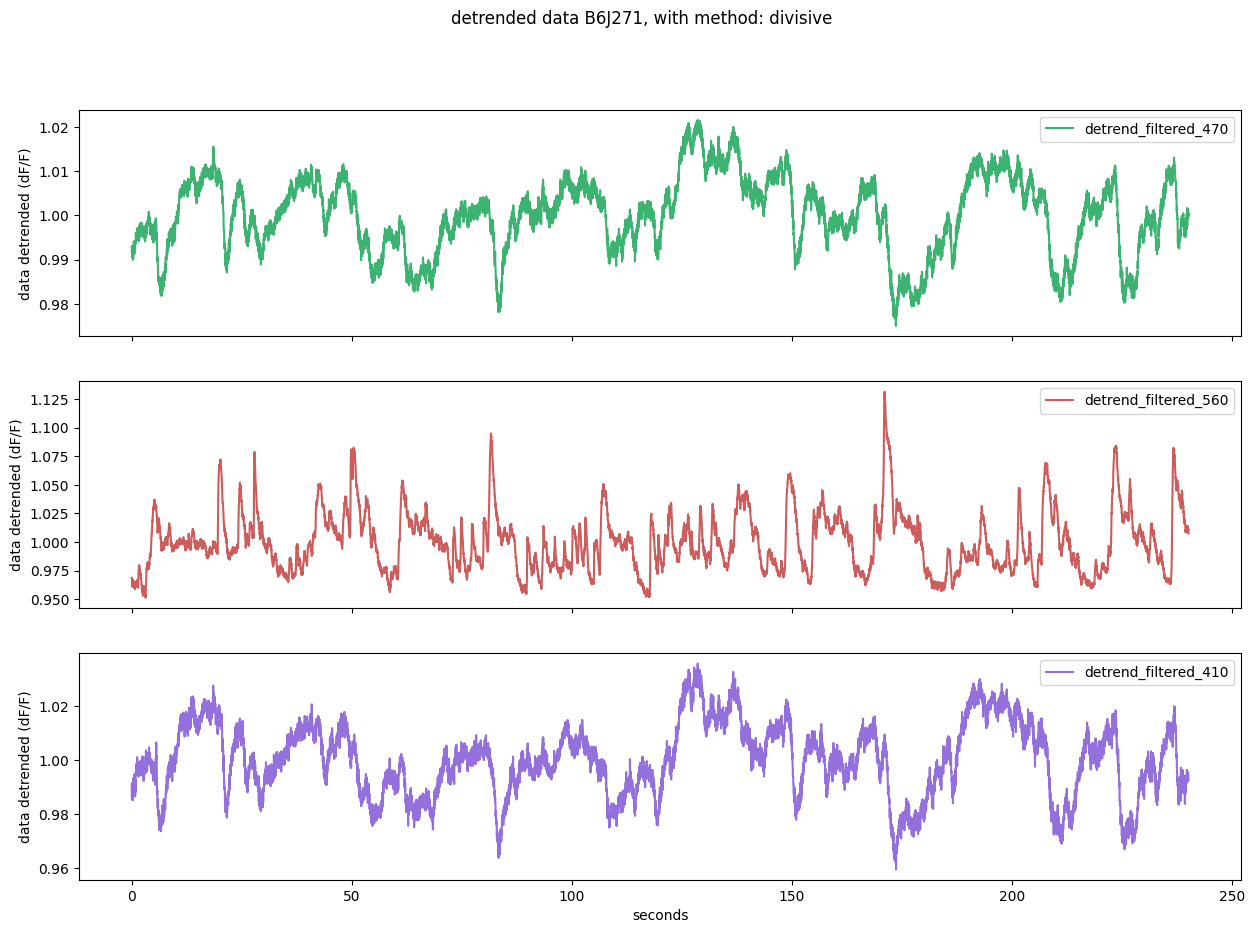

In [8]:
processed.data_detrended, processed.exp_fits = processed.detrend(plot = True, method = "divisive")

### Motion correction
There is a motion correction function that can be used. It is now set to use the 560 nm signal, because of my doubts with the relevans of the 410 nm signal as isosbestic trace. For now, I recommend not running this one.
Check function before use, not checked in Jan 2025. 

In [9]:
#processed.motion_corr = processed.movement_correct(plot = True)

### Z-scoring
Standard Z-scoring of the signal.  
If divisive detrending was used, this is the z-scored dF/F.  
If subtractive detrending was used, this is the z-scored signal.  
motion = False does not use motion corrected signal  
savefig = False by default, True will save the figure

Motion correction NOT APPLIED to z-score


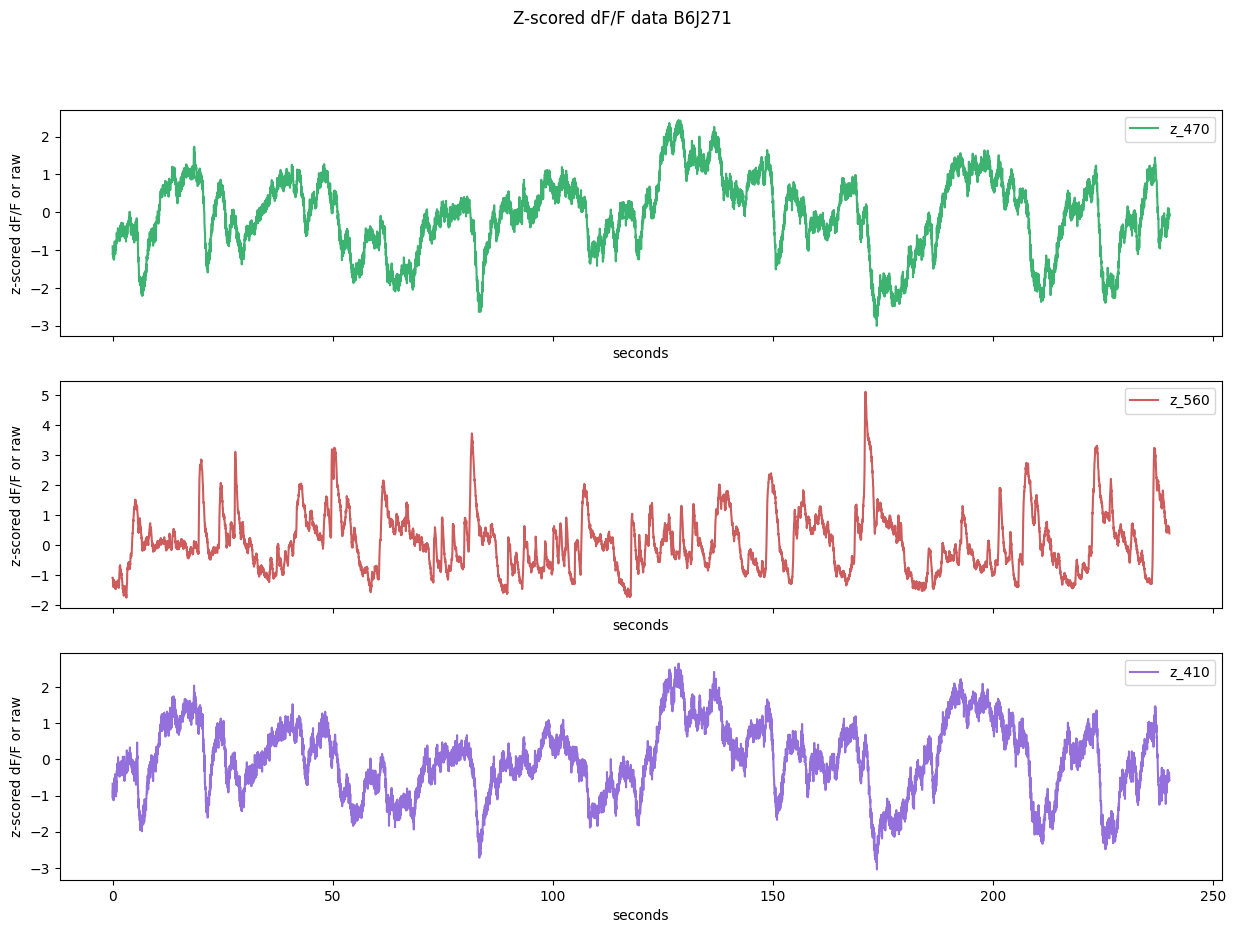

In [10]:
processed.zscored = processed.z_score(motion = False, plot = True)

### Delta F / F

WITH divisive detrending, this is not needed

This is a standard way of calculating the detla F over F signal, i.e. the % change in signal. I do think it is a bit weird to use the detrending exponential fit again. I have wondered if I should change it to just a linear fit to the current detrended signal. For now I do this based on the fiber photometry primer paper code: https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

Again, 'motion' can be set to True, bu tis defaulth False
savefig = False by default, True will save the figure 

The method used for detrending was divisive, deltaF/F has been already calculated


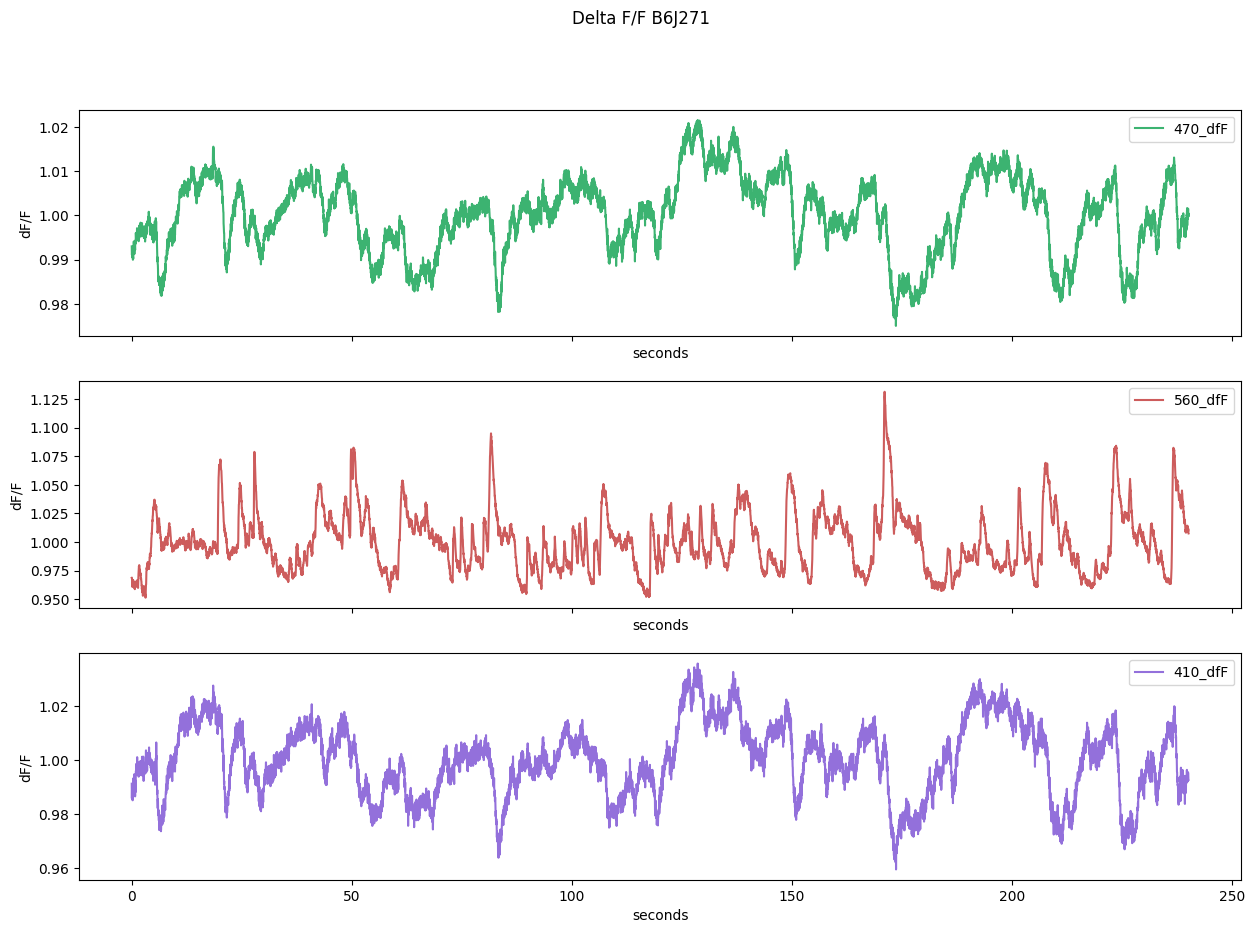

In [11]:
processed.deltaF_F = processed.get_deltaF_F(motion = False, plot = True)

### Add crucial info
`processed.crucial_info = processed.add_crucial_info()`  
This has been removed and now added to the self.Info instead of columns in the saved fluorescence csv file

In [12]:
# show structure of data frame to be saved 
processed.show_structure()


=== DataFrames ===
data: 7205 rows × 7 columns
data_detrended: 7205 rows × 3 columns
data_seconds: 7205 rows × 1 columns
deltaF_F: 7205 rows × 3 columns
exp_fits: 7205 rows × 3 columns
filtered: 7205 rows × 3 columns
rawdata: 7205 rows × 6 columns
signals: 7205 rows × 3 columns
zscored: 7205 rows × 3 columns

=== Properties ===
colors: list
info: dict
mousename: str
path: str
save_path: str
sensors: dict

=== Methods ===
create_basic, detrend, extract_events, get_deltaF_F, get_info, low_pass_filt, movement_correct, plot_all_signals, show_structure, write_info_csv, write_preprocessed_csv, z_score


In [13]:
processed.plot_all_signals()

/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Save it as a .csv files
from Hilde  
This function will lead to it all being saved as a csv file which can easily be read as a pandas dataframe when the data is to be analysed.
First it is the info csv, which I for now save, but never actually use...
Then it is the main csv file which is very useful indeed. For this one you can add Events = True to also save the events, and motion_correct = True if you have doen motion correction and want to use this.The only difference for the latter, is really that it also saved the motion corrected raw signal. Regardless, if you did use motion correction for deltaF and z-score, this is the version that will be saved

In [14]:
#again it ensures that the folder to save in already exists, since the csv must have somewhere to be
processed.info_csv = processed.write_info_csv()
processed.data_csv = processed.write_preprocessed_csv()
#optional:, motion_correct = True, Onix_align =False

Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment


### Have a look
By importing pandas, you can now read the file, by compying the path from above and adding 'preprocessed.csv' which is the name of your new file. Sorry about the unnamed file. It can be removed. I'll do that

In [15]:
processed.save_path

'/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2717-2024-12-12T12-54-49_processedData/photometry'

In [16]:
import pandas as pd
pd.read_csv(processed.save_path+'/Events.csv')

,TimeStamp,Name,State
0,36529.280,Input1,0
1,39604.675,Input1,1
2,44286.183,Input1,0
3,46060.259,Input1,1
4,48488.701,Input1,0
...,...,...,...
67,222740.811,Input1,1
68,225471.526,Input1,0
69,229114.879,Input1,1
70,230409.226,Input1,0


In [17]:
pd.read_csv(processed.save_path+'/Processed_fluorescence.csv')

,TimeStamp,470_dfF,560_dfF,410_dfF,z_470,z_560,z_410
0,0.011110,0.992992,0.968807,0.991249,-0.902249,-1.085010,-0.673398
1,0.044447,0.991126,0.968912,0.985834,-1.120711,-1.080996,-1.078963
2,0.077776,0.991361,0.967109,0.989053,-1.093145,-1.149858,-0.837872
3,0.111110,0.990557,0.965190,0.987159,-1.187344,-1.223135,-0.979704
4,0.144444,0.990729,0.960855,0.987713,-1.167179,-1.388660,-0.938241
...,...,...,...,...,...,...,...
7200,239.979109,1.000120,1.010451,0.995508,-0.067763,0.505346,-0.354403
7201,240.012442,1.001502,1.009331,0.995319,0.094106,0.462579,-0.368552
7202,240.045770,0.999684,1.011586,0.995117,-0.118808,0.548666,-0.383705
7203,240.079095,1.000464,1.007931,0.992728,-0.027403,0.409092,-0.562651


### Mass production
When several paths are saved in one list, we can just loop through the list and create all the files. It is  a good idea to have a look at all the saved plots anyways. Also, for now you must wait for the prompts to add the crucial info. If you prefer I can change it so that you can add that some other way, but I like this way so I can be certain that I get it right. 

In [18]:
import matplotlib.pyplot as plt
from preprocess_functions import preprocess #preprocess is a class containing all the function, not sure why I made it a class
#May have to specify the location of the preprocess_functions files relative to this one
import numpy as np
import os

In [19]:
paths = []
rootdir = '/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1'

for root, dirs, files in os.walk(rootdir):
    for filename in files:
        if filename == 'Fluorescence-unaligned.csv':
            # Get the folder one level higher
            parent_folder = os.path.dirname(root)
            paths.append(parent_folder)

# Print all the paths
[print(path) for path in paths] 

sensors = {'470':'g5-HT3', '560':'rG1', '410':'g5-HT3'}
target_area = ('X') #ASSUMES the same target area for all folders, DANGER
filtmethod = "auto"
detrendmethod = "divisive"

/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2718-2024-12-12T13-28-14
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2722-2024-12-12T15-11-47
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2723-2024-12-12T15-44-01
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2717-2024-12-12T13-00-21
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2719-2024-12-12T13-59-38
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2717-2024-12-12T12-54-49
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2721-2024-12-12T14-39-22
/Users/rancze/Documents/Data/vestVR/Cohort1/VestibularMismatch_day1/B6J2721-2024-12-12T14-40-11


In [20]:
for path in paths: 
    processed = preprocess(path, sensors)
    processed.info = processed.get_info()
    (
        processed.rawdata, 
        processed.data, 
        processed.data_seconds, 
        processed.signals, 
    ) = processed.create_basic(
        cutstart = False,
        cutend = False,
        target_area = target_area
    )
    #processed.events = processed.extract_events()
    processed.filtered = processed.low_pass_filt(method = filtmethod)
    processed.data_detrended, processed.exp_fits = processed.detrend(method = detrendmethod)
    processed.motion_corr = processed.movement_correct() #results of this are generally not used 
    processed.zscored = processed.z_score(motion = False)
    processed.deltaF_F = processed.get_deltaF_F(motion = False)
    processed.plot_all_signals()
    processed.info_csv = processed.write_info_csv()
    processed.data_csv = processed.write_preprocessed_csv()#Events = True) #optional: Events = True, motion_correct = True


Preprocessing data for B6J271 in session 2024-12-12T13-28-14...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [105, 17.2, 4.42, 115, 8.04e-07]
Detrending filtered_560 with params: [83.1, 7.87, 8.24, 1.43e+03, 0.0762]
Detrending filtered_410 with params: [17.4, 1.59, 1.88, 644, 0.175]
For 410/470 motion correction, slope = 0.557 and R-squared = 0.596
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J272 in session 2024-12-12T15-11-47...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [498, 0.00949, 57, 781, 2.29e-08]
Detrending filtered_560 with params: [164, 3.46, 21.5, 598, 7.5e-08]
Detrending filtered_410 with params: [79.2, 1.96e-05, 13.7, 566, 8.62e-09]
For 410/470 motion correction, slope = 1.027 and R-squared = 0.910
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J272 in session 2024-12-12T15-44-01...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [36.6, 0.925, 1.31, 138, 0.00479]
Detrending filtered_560 with params: [54.2, 0.486, 2.02, 208, 0.0279]
Detrending filtered_410 with params: [7.7, 0.207, 0.832, 282, 0.21]
For 410/470 motion correction, slope = 1.106 and R-squared = 0.275
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J271 in session 2024-12-12T13-00-21...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [34.1, 0.234, 2.4, 501, 0.0124]
Detrending filtered_560 with params: [74.7, 17.8, 0.00204, 2.5e+03, 0.756]
Detrending filtered_410 with params: [8.7, 8.16e-12, 2.67, 1.63e+03, 2.91e-11]
For 410/470 motion correction, slope = 0.587 and R-squared = 0.834
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J271 in session 2024-12-12T13-59-38...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [2.13e-12, 0.687, 20.8, 1.54e+04, 0.00322]
Detrending filtered_560 with params: [10.6, 2.23, 35.5, 3.6e+04, 0.00464]
Detrending filtered_410 with params: [6.44, 0.0646, 0.957, 165, 0.00523]
For 410/470 motion correction, slope = -0.241 and R-squared = 0.107
signal could not be motion corrected
1.2414129636507976 -0.2414198340870298
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J271 in session 2024-12-12T12-54-49...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [2.41e-06, 25.7, 38.9, 3.74e+03, 3.39e-08]
Detrending filtered_560 with params: [90.8, 0.53, 9.36, 124, 6.82e-08]
Detrending filtered_410 with params: [10.9, 5.38, 1.1, 204, 7.75e-07]
For 410/470 motion correction, slope = 0.610 and R-squared = 0.910
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J272 in session 2024-12-12T14-39-22...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [19.3, 0.509, 2.79e-13, 559, 0.00664]
Detrending filtered_560 with params: [68.8, 0.9, 23.8, 483, 0.000112]
Detrending filtered_410 with params: [12.9, 0.255, 0.383, 32.3, 0.119]
For 410/470 motion correction, slope = 0.482 and R-squared = 0.852
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment

Preprocessing data for B6J272 in session 2024-12-12T14-40-11...

Filtering 470 with method auto at 14.0 Hz
Filtering 560 with method auto at 14.0 Hz
Filtering 410 with method auto at 14.0 Hz
Detrending filtered_470 with params: [6.54, 0.122, 13, 3.6e+04, 1.02e-05]
Detrending filtered_560 with params: [11, 6.09, 72.6, 9.33e+03, 0.0176]
Detrending filtered_410 with params: [10.5, 0.824, 1.79, 1.39e+03, 0.0852]
For 410/470 motion correction, slope = 0.558 and R-squared = 0.541
Motion correction NOT APPLIED to z-score
The method used for detrending was divisive, deltaF/F has been already calculated


/Users/rancze/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:786: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Info.csv saved
Processed_fluorescence.csv saved
Original Events.csv saved to Events.csv to be used for ONIX alingment
